## Sensitivity and Specificity

In [1]:
# in this code block we gather all imports

# to read CSV and for use with the library ppscore
import pandas as pd
from pandas.api.types import CategoricalDtype

# for use with sklearn and for EDA
import numpy as np

# Data Split
from sklearn.model_selection import train_test_split

# Normalization and Standardization
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import RobustScaler

# Plots
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm

# EDA
import ppscore as pps
from scipy import stats

# PCA
from sklearn.decomposition import PCA

# Decision Tree Classifier
from sklearn import tree
from sklearn import svm

# Tensors and Artificial Neural Networks
import torch
import torch.nn as nn


In [2]:
# in this code block we determine the device to use depending on GPU availability

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('This Computation is running on {}.'.format(device))

This Computation is running on cpu.


In [3]:
# in this code block we define a function to read the dataset and perform some basic preprocessing

def load_dataset(path: str, sep: str, target_column_name: str, columns_to_drop: list, column_name_mapping: dict, target_class_mapping: dict):

    target_column_is_index = False 
    target_column_index = -1
    if(target_column_name.isnumeric()):
        target_column_is_index = True
        target_column_index = int(target_column_name)

    # read the CSV file
    # using separator character semicolon
    X_original_y_pd = pd.read_csv(path, sep=sep, skipinitialspace=True)

    # make column names pythonic
    # so that they can be used in code where applicable
    X_original_y_pd.columns = X_original_y_pd.columns.str.replace(" ", "_")

    for column_to_drop in columns_to_drop:
        X_original_y_pd.drop(column_to_drop, axis=1, inplace=True)

    X_original_y_pd.rename(column_name_mapping, axis=1, inplace=True)

    X_original_y_pd[target_column_name] = X_original_y_pd[target_column_name].map(target_class_mapping)

    # on a side note we choose to sort the data frame by the target column 
    #X_original_y_pd.sort_values(by='species', ascending=True, axis=0, inplace=True)

    X_y_np = X_original_y_pd.to_numpy()

    # number of instances often referred to as just n
    n_samples = X_y_np.shape[0]
    print(f"n_samples={n_samples}")

    # number of target variables
    n_targets = 1
    print(f"n_targets={n_targets}")

    # number of target classes
    #n_target_classes = 3
    #print(f"n_target_classes={n_target_classes}")

    # number of features
    n_features = X_y_np.shape[1] - n_targets
    print(f"n_features={n_features}")

    assert X_y_np.shape == (n_samples, n_features + n_targets)
    assert X_y_np.shape == (n_samples, n_features + n_targets)

    X_original_pd = X_original_y_pd.copy().drop(target_column_name, axis=1)
    X_original_np = X_original_pd.to_numpy()
    assert X_original_np.shape == (n_samples,n_features)

    y_pd = X_original_y_pd[target_column_name].copy()
    y_np = y_pd.to_numpy()
    assert y_np.shape == (n_samples,)

    X_original = torch.from_numpy(X_original_np)
    y = torch.from_numpy(y_np)

    # we need the target data to be of data type long for the loss function to work
    if y.dtype != torch.int64:
        y = y.long()
    assert X_original.dtype == torch.float64
    assert y.dtype == torch.int64

    # also create a tensor that contains the 4 features and the target
    y_unsqueezed = y.unsqueeze(1)
    X_original_y = torch.cat((X_original, y_unsqueezed), 1)
    assert X_original_y.shape == (n_samples, n_features + n_targets)
    assert X_original_y.dtype == torch.float64

    return (X_original_pd, y_pd, X_original_np, y_np, X_original, y, X_original_y_pd, X_original_y)


In [4]:
# in this code block we define a function to normalize a dataset

def standardize_dataset(X_original_np):
    scaler = StandardScaler()
    X_np = scaler.fit_transform(X_original_np)
    X = torch.from_numpy(X_np)

    return (X_np, X)


In [5]:
# in this code block we define a function to split the dataset into for training, validation, test

def split_dataset(X, y, n_targets):

    n_samples = X.shape[0]
    n_features = X.shape[1]

    # we first attempted to do this purely in PyTorch which is still a bit difficult
    #dataset_known = torch.from_numpy(dataset_known_np)
    #dataset_known_subsets = torch.utils.data.random_split(dataset_known, [int(n_samples * 0.7), int(n_samples * 0.3)])
    #dataset_known_train_subset = dataset_known_subsets[0]
    #dataset_known_test_subset = dataset_known_subsets[1]
    #assert len(dataset_known_train_subset) == 105
    #assert len(dataset_known_test_subset) == 45

    # however many people still use pandas and sklearn which we follow for now
    X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.20, random_state=77)

    X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.20, random_state=77)

    del X_tmp
    del y_tmp

    assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == n_samples
    assert y_train.shape[0] + y_val.shape[0] + y_test.shape[0] == n_samples

    assert X_train.ndim == 2
    assert X_train.shape[1] == n_features
    assert X_train.dtype == torch.float64

    assert X_val.ndim == 2
    assert X_val.shape[1] == n_features
    assert X_val.dtype == torch.float64

    assert X_test.ndim == 2
    assert X_test.shape[1] == n_features
    assert X_test.dtype == torch.float64

    assert (n_targets == 1 and y_train.ndim == 1) or (n_targets > 1 and y_train.ndim == 2)
    assert y_train.dtype == torch.int64

    assert (n_targets == 1 and y_val.ndim == 1) or (n_targets > 1 and y_val.ndim == 2)
    assert y_val.dtype == torch.int64

    assert (n_targets == 1 and y_test.ndim == 1) or (n_targets > 1 and y_test.ndim == 2)
    assert y_test.dtype == torch.int64

    X_train_np = X_train.numpy()
    y_train_np = y_train.numpy()
    X_val_np = X_val.numpy()
    y_val_np = y_val.numpy()
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy()

    return (X_train, y_train, X_train_np, y_train_np, X_val, X_val_np, y_val, y_val_np, X_test, X_test_np, y_test, y_test_np)


In [6]:
# in this code block we define a function to perform an EDA

def explore_dataset(X_original_y_pd, X_y_np, n_target_classes, target_column_name):

    target_column_cat_name = f"{target_column_name}_cat"
    n_target_classes_range = range(n_target_classes)
    target_classes_int = [*n_target_classes_range]

    # number of instances
    print(f"n={X_y_np.shape[0]}")

    # location parameters
    print(f"mean={X_y_np.mean(axis=0)}")
    print(f"trimmed_mean={stats.trim_mean(X_y_np.astype('float32'), proportiontocut=0.10, axis=0)}")
    print(f"mode={stats.mode(X_y_np, keepdims=True)}")

    # statistical dispersion measures
    def range_np(a: np.ndarray) -> np.ndarray:
        result = a.max(axis=0) - a.min(axis=0)
        return result

    print(f"range={range_np(X_y_np)}")
    print(f"iqr={stats.iqr(X_y_np, axis=0)}")

    print(f"percentile_10={np.percentile(X_y_np, 10.0, axis=0)}")
    print(f"percentile_25={np.percentile(X_y_np, 25.0, axis=0)}")
    print(f"median={np.percentile(X_y_np, 50.0, axis=0)}")
    print(f"percentile_75={np.percentile(X_y_np, 75.0, axis=0)}")
    print(f"percentile_90={np.percentile(X_y_np, 90.0, axis=0)}")

    def mad_np(a: np.ndarray) -> np.ndarray:
        result = np.mean(np.absolute(a - np.mean(a, axis=0)), axis=0)
        return result

    print(f"mad={mad_np(X_y_np)}")

    print(f"std={X_y_np.std(axis=0)}")
    print(f"var={X_y_np.var(axis=0)}")

    # association measures
    print(f"\ncorrelation_matrix=\n{np.corrcoef(X_y_np, rowvar=False).round(decimals=2)}")

    # we have a look at a scatter matrix
    pd.plotting.scatter_matrix(X_original_y_pd, 
                            c=X_original_y_pd[target_column_name], 
                            figsize=(17, 17),
                            cmap = cm['cool'],
                            diagonal = 'kde')

    # for the computation of predictive power scores we use pandas categorical data type for class_cat
    class_categories_pd = CategoricalDtype(categories=target_classes_int, ordered=True)
    X_original_y_cat_pd = X_original_y_pd.copy()
    X_original_y_cat_pd[target_column_cat_name] = X_original_y_pd[target_column_name].astype(class_categories_pd)
    X_original_y_cat_pd.drop(target_column_name, axis=1, inplace=True)

    #predictive_power_score_matrix_all_pd = pps.matrix(df_pd_all, output='df')
    predictive_power_scores_pd = pps.predictors(X_original_y_cat_pd, y=target_column_cat_name, output='df')
    predictive_power_scores_pd.style.background_gradient(cmap='twilight', low=0.0, high=1.0)
    print(predictive_power_scores_pd)



In [7]:
# in this code block we define a function to train a Decision Tree Classifier

def train_decision_tree_classifier(X_train_np, y_train_np, max_depth):
    dtc = tree.DecisionTreeClassifier(random_state=42, max_depth=max_depth)
    dtc.fit(X_train_np, y_train_np)
    return dtc


In [8]:
# in this code block we define a function to train a Support Vector Machine Classifier

def train_support_vector_machine_classifier(X_train_np, y_train_np):
    svmc = svm.SVC(kernel='linear', probability=True)
    svmc.fit(X_train_np, y_train_np)
    return svmc


In [9]:
# in this code block we define a function to assert all elements in an array are 0 or 1

def assert_elements_are_zero_or_one(a):
    assert len(np.ma.masked_where(((a == 0) | (a == 1)).all(), a).compressed()) == 0


In [10]:
# in this code block we compute a binary confusion matrix with corresponding metrics

def compute_binary_confusion_matrix_with_corresponding_metrics(y_test_np, y_test_pred_class_np):
    assert y_test_np.shape == y_test_pred_class_np.shape
    assert y_test_np.shape == (y_test_np.shape[0],)
    assert_elements_are_zero_or_one(y_test_np)
    assert_elements_are_zero_or_one(y_test_pred_class_np)
    
    n_samples = y_test_np.shape[0]
    assert n_samples == y_test_pred_class_np.shape[0]

    n_p = y_test_np.sum()
    n_n = ((y_test_np - 1) * -1).sum()
    assert n_p + n_n == n_samples

    y_tmp = (y_test_np * 2) - y_test_pred_class_np
    n_tp = np.count_nonzero(y_tmp == 1)
    n_fp = np.count_nonzero(y_tmp == 2)
    n_tn = np.count_nonzero(y_tmp == 0)
    n_fn = np.count_nonzero(y_tmp == -1)
    assert n_tp + n_fp + n_tn + n_fn == n_samples

    cm = np.asarray([[n_tp, n_fn], [n_fp, n_tn]])

    return cm, n_samples, n_p, n_n
    


n_samples=150
n_targets=1
n_features=4
     sepal_length  sepal_width  petal_length  petal_width  species
0             5.1          3.5           1.4          0.2        0
1             4.9          3.0           1.4          0.2        0
2             4.7          3.2           1.3          0.2        0
3             4.6          3.1           1.5          0.2        0
4             5.0          3.6           1.4          0.2        0
..            ...          ...           ...          ...      ...
145           6.7          3.0           5.2          2.3        1
146           6.3          2.5           5.0          1.9        1
147           6.5          3.0           5.2          2.0        1
148           6.2          3.4           5.4          2.3        1
149           5.9          3.0           5.1          1.8        1

[150 rows x 5 columns]
n=150
mean=[5.84333333 3.054      3.75866667 1.19866667 0.33333333]
trimmed_mean=[5.8083334  3.0391667  3.7608333  1.1841667  0.29166

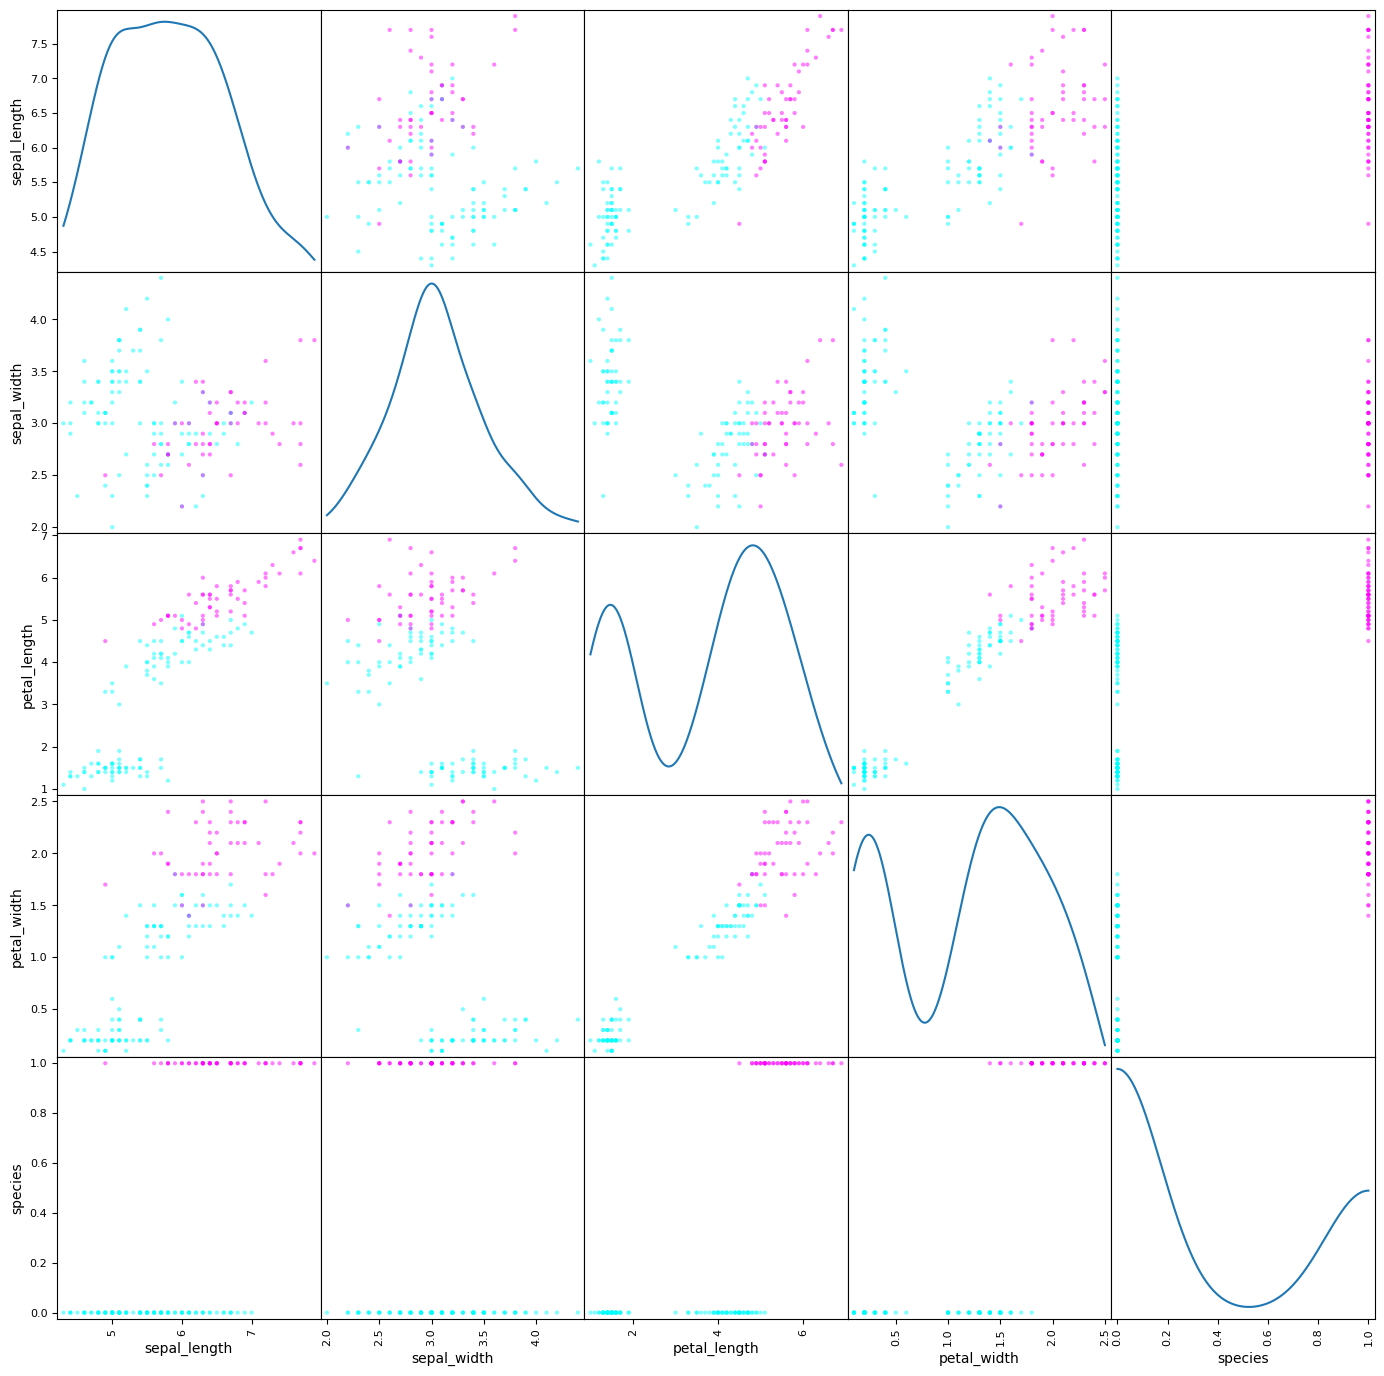

In [11]:
def play_with_iris_dataset_made_binary():
    n_targets = 1
    n_target_classes = 3

    target_column_name = 'species'

    columns_to_drop = ['Id']

    column_name_mapping = {'SepalLengthCm': 'sepal_length',
        'SepalWidthCm': 'sepal_width',
        'PetalLengthCm': 'petal_length',
        'PetalWidthCm': 'petal_width',
        'Species': 'species'}

    # we make the dataset binary by mapping two classes to 0 just for experimentation!
    target_class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 0, 'Iris-virginica': 1}
    assert len(target_class_mapping) == n_target_classes   

    X_original_pd, y_pd, X_original_np, y_np, X_original, y, X_original_y_pd, X_original_y = load_dataset("../../data/iris.csv",
        ',', target_column_name, columns_to_drop, column_name_mapping, target_class_mapping)

    print(X_original_y_pd)

    X_np, X = standardize_dataset(X_original_np)

    X_train, y_train, X_train_np, y_train_np, X_val, X_val_np, y_val, y_val_np, X_test, X_test_np, y_test, y_test_np = split_dataset(X, y, n_targets)

    explore_dataset(X_original_y_pd, X_original_y_pd.to_numpy(), n_target_classes, 'species')

    #perform_pca(3, X_original_np, X_original_y_pd, target_column_name)

    #clf = train_decision_tree_classifier(X_train_np, y_train_np, 1)
    clf = train_support_vector_machine_classifier(X_train_np, y_train_np)

    y_test_pred_class_np = clf.predict(X_test)
    y_test_pred_proba_np = clf.predict_proba(X_test)

    print(y_test_np)
    print(y_test_pred_class_np)
    #print(y_test_pred_proba_np)

    cm, n_samples, n_p, n_n = compute_binary_confusion_matrix_with_corresponding_metrics(y_test_np, y_test_pred_class_np)

    print(f"confusion_matrix=\n{cm}")
    print(f"n_samples={n_samples}")
    print(f"n_p={n_p}")
    print(f"n_n={n_n}")

play_with_iris_dataset_made_binary()
